<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Descripción-del-problema" data-toc-modified-id="Descripción-del-problema-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Descripción del problema</a></span></li><li><span><a href="#Exploración-de-datos" data-toc-modified-id="Exploración-de-datos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploración de datos</a></span></li><li><span><a href="#Análisis-de-datos" data-toc-modified-id="Análisis-de-datos-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Análisis de datos</a></span></li><li><span><a href="#Entrenamiento-del-modelo" data-toc-modified-id="Entrenamiento-del-modelo-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Entrenamiento del modelo</a></span><ul class="toc-item"><li><span><a href="#Creación-de-características" data-toc-modified-id="Creación-de-características-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Creación de características</a></span></li><li><span><a href="#Prueba-de-cordura" data-toc-modified-id="Prueba-de-cordura-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Prueba de cordura</a></span></li><li><span><a href="#Modelo-1:-Árbol-de-Decisión" data-toc-modified-id="Modelo-1:-Árbol-de-Decisión-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Modelo 1: Árbol de Decisión</a></span></li><li><span><a href="#Modelo-2:-Bosque-aleatorio" data-toc-modified-id="Modelo-2:-Bosque-aleatorio-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Modelo 2: Bosque aleatorio</a></span></li><li><span><a href="#Modelo-3:-LightGBM" data-toc-modified-id="Modelo-3:-LightGBM-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Modelo 3: LightGBM</a></span></li></ul></li><li><span><a href="#Verificando-con-conjunto-de-prueba" data-toc-modified-id="Verificando-con-conjunto-de-prueba-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Verificando con conjunto de prueba</a></span></li><li><span><a href="#Conclusión" data-toc-modified-id="Conclusión-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusión</a></span></li></ul></div>

## Descripción del problema

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. 

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Exploración de datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

Importamos los datos históricos del archivo de `taxi.csv`

In [2]:
try:
    taxi_data = pd.read_csv('datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    taxi_data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
taxi_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Vamos a revisar un resumen de los datos.

In [4]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


No hay datos ausentes y las columnas tienen el tipo correcto de variable. El intervalo de tiempo es de cada 10 minutos en la tabla, como se va a predecir la cantidad de taxis para la siguiente hora, se van a agrupar los datos por hora.

In [5]:
# Ordenando por si acaso no estuvieran ordenadas las fechas
taxi_data.sort_index(inplace=True)

In [6]:
taxi_data = taxi_data.resample('1H').sum()
taxi_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Con los datos agrupados por hora, continuamos con el análisis.

## Análisis de datos

Determinaremos nuestro rango de tiempo disponible.

In [7]:
print(f'{min(taxi_data.index)} - {max(taxi_data.index)}')

2018-03-01 00:00:00 - 2018-08-31 23:00:00


El rango va desde el primero de marzo hasta el 31 de agosto. Tenemos 6 meses de datos disponibles. Vamos a revisar como varían los pedidos de taxis a lo largo de este tiempo.

<AxesSubplot:xlabel='datetime'>

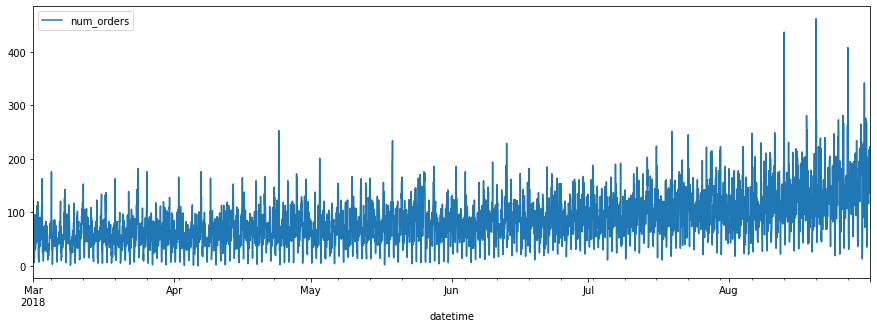

In [8]:
taxi_data.plot(figsize=(15,5))

A simple vista, parece que hay un patrón que se repite cada cierto periodo. Vamos a revisar un intervalo más pequeño, de una semana, para observar mejor este comportamiento.

<AxesSubplot:xlabel='datetime'>

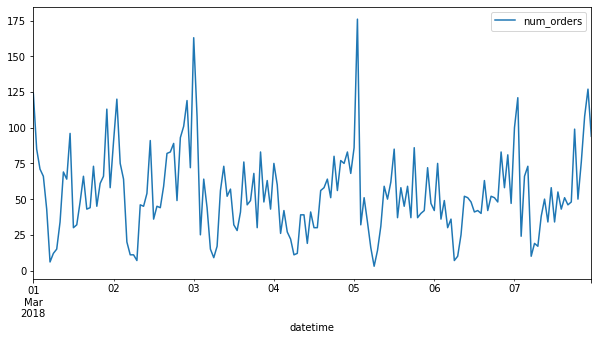

In [9]:
taxi_data['2018-03-01':'2018-03-07'].plot(figsize=(10,5))

Cada día se observa que un patrón se repite. Vamos a revisar gráficar la tendencia y estacionalidad de este rango.

Text(0.5, 1.0, 'Estacionalidad')

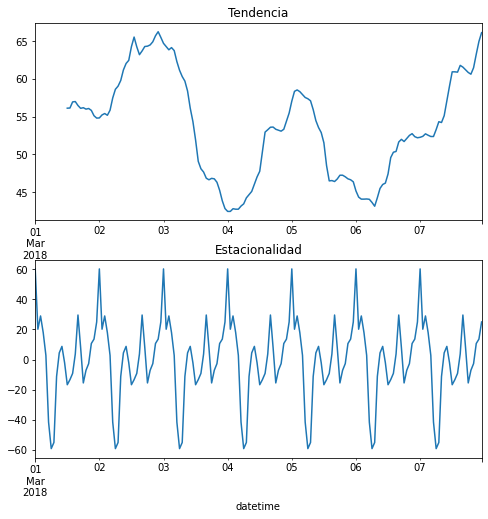

In [10]:
decomposed = seasonal_decompose(taxi_data)

plt.figure(figsize=(8, 8))

plt.subplot(211)
decomposed.trend['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(212)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Estacionalidad')

En efecto, hay un patrón que se repite cada día, el punto más bajo de pedidos ocurre a las 6 am, mientras el pico de mayor pedido se da a media noche. La tendencia no se puede apreciar mucho en este corto periodo de tiempo, vamos revisar la tendencia para el rango completo de tiempos disponibles.

Text(0.5, 1.0, 'Tendencia')

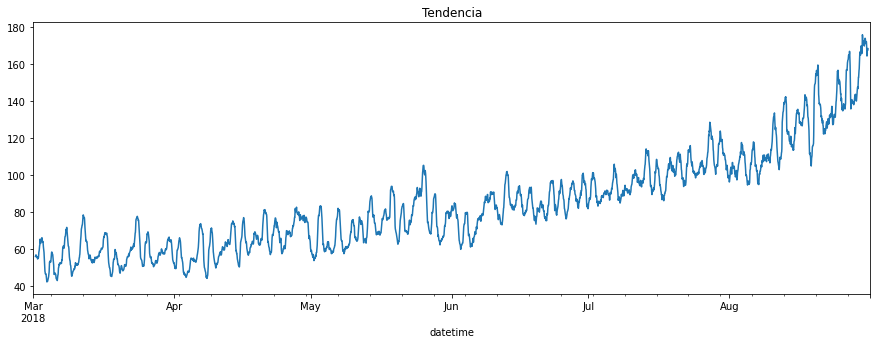

In [11]:
decomposed.trend.plot(figsize=(15,5))
plt.title('Tendencia')

Parece que la tendencia indica que los pedidos de taxi tienden a subir con el tiempo. Podría ser de valor usar la característica de mes y día del mes en la siguiente sección.

## Entrenamiento del modelo

### Creación de características

Vamos a crear características para nuestros datos. Se iterará con algunas combinaciones de carácterísticas. Consideraremos que el mes, día del mes, día de la semana y la hora como información que podría ayudar al entrenamiento, éstas permanecerán en todas las iteraciones. Ciertas carácterísticas que sí variarán en cada combinación son la cantidad de horas usadas para la media movil y el desfase máximo a probar.

In [12]:
def add_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

Esta función nos devolverá una tabla con las características añádidas a nuestro conjunto de datos. Una vez creado este conjunto, continuamos diviendo los datos, entre datos de entrenamiento, validación y prueba. Los de prueba deben ser el 10% de los datos disponibles y usaremos el 10% también para la validación. Con estos datos, se deberá entrenar y validar el modelo. 

### Prueba de cordura

Aplicaremos una prueba de cordura para obtener la Raiz del Error Cuadrático Medio. Se va a pronosticar nuestra variable sin realizar entrenamiento previo. Primero separamos nuestros datos en los conjuntos de entrenamiento, validación y prueba.

In [13]:
# Añadimos las características antes de aplicar el split de datos
add_features(taxi_data, 6, 9)

# Dividimos en conjunto de entrenamiento, validación y prueba (8:1:1)
train_valid, test = train_test_split(taxi_data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.111)

# La media movil añade valores ausentes en las primeras filas de los datos. Vamos a eliminarlos.
train = train.dropna()

# Separamos las característica del objetivo
X_train = train.drop('num_orders', axis=1)
X_valid = valid.drop('num_orders', axis=1)

y_train = train['num_orders']
y_valid = valid['num_orders']

Ahora, para el pronóstico, cada valor de x(t) será obtenido a partir del previo, es decir x(t-1). Usaremos la función shift para esto. El último valor del conjunto de entrenamiento será el primer valor de la predicción.

In [14]:
pred_previous = y_valid.shift()
pred_previous.iloc[0] = y_train.iloc[-1]

RECM_previous = mean_squared_error(y_valid, pred_previous, squared=False)
print('RECM:', RECM_previous)

RECM: 47.246345832986236


La predicción con este método dió un RECM de 47.25, lo usaremos como límite superior de error para los siguientes modelos a entrenar.

### Modelo 1: Árbol de Decisión

Vamos a comenzar con un modelo de arbol de decisión para predecir los pedidos de taxis. Buscaremos el mejor modelo variando el hiperparámetro de profundidad máxima de 2 a 10.

In [15]:
seed = 333
max_depths = range(2, 11)

# Consideramos el máximo RECM como el obtenido de la prueba de cordura
best_RECM_DTR = RECM_previous 

for max_depth in max_depths:
    model_DTR = DecisionTreeRegressor(random_state=seed, max_depth=max_depth)
    model_DTR.fit(X_train, y_train)
    predict_valid = model_DTR.predict(X_valid)
    RECM_DTR = mean_squared_error(y_valid, predict_valid, squared=False)
    if RECM_DTR < best_RECM_DTR:
        best_RECM_DTR = RECM_DTR
        best_max_depth = max_depth

print(f'RECM para modelo de árbol de decisión: {best_RECM_DTR:.2f}')
print(f'Usando como hiperparámetro max_depth={best_max_depth}')

RECM para modelo de árbol de decisión: 33.70
Usando como hiperparámetro max_depth=9


Para estos datos, con profundidad máxima del arbol de 9, se encontró el menor RECM. Se obtuvo un error de 33.70 con este modelo. Vamos a compararlo con los demás modelos a continuación. 

### Modelo 2: Bosque aleatorio

In [16]:
max_depths = range(2, 11)
n_estimators = range(100, 150, 5)

best_RECM_RFR = RECM_previous # Consideramos el máximo RECM como el obtenido de la prueba de cordura

for max_depth in max_depths:
    for n_est in n_estimators:
        model_RFR = RandomForestRegressor(random_state=seed, max_depth=max_depth, n_estimators=n_est)
        model_RFR.fit(X_train, y_train)
        predict_valid = model_RFR.predict(X_valid)
        RECM_RFR = mean_squared_error(y_valid, predict_valid, squared=False)
        if RECM_RFR < best_RECM_RFR:
            best_RECM_RFR = RECM_RFR
            best_max_depth = max_depth
            best_n_est = n_est

print(f'RECM para modelo de bosque aleatorio: {best_RECM_RFR:.2f}')
print(f'Usando como hiperparámetro max_depth={best_max_depth}')
print(f'Usando como hiperparámetro n_estimators={best_n_est}')

RECM para modelo de bosque aleatorio: 32.79
Usando como hiperparámetro max_depth=10
Usando como hiperparámetro n_estimators=145


Ajustando los hiperparámetros, se encontró un error de 32.79, para un max_depth de 10 y un n_estimator de 145. Es posible que hayan mejores valores aumentando ambos parámetros, pero el tiempo se volvería muy largo para entrenar estas combinaciones.

### Modelo 3: LightGBM

In [17]:
learning_rates = [0.001, 0.01, 0.1, 1]
max_depths = range(5, 21)

best_RECM_lGBM = RECM_previous # Consideramos el máximo RECM como el obtenido de la prueba de cordura

for max_depth in max_depths:
    for learning_rate in learning_rates:
        model_lGBM = lgb.LGBMRegressor(random_state=seed, learning_rate=learning_rate, max_depth=max_depth)
        model_lGBM.fit(X_train, y_train)
        predict_valid = model_lGBM.predict(X_valid)
        RECM_lGBM = mean_squared_error(y_valid, predict_valid, squared=False)
        if RECM_lGBM < best_RECM_lGBM:
            best_RECM_lGBM = RECM_lGBM
            best_max_depth = max_depth
            best_learning_rate = learning_rate
            
print(f'RECM para modelo de lightGBM: {best_RECM_lGBM:.2f}')
print(f'Usando como hiperparámetro max_depth={best_max_depth}')
print(f'Usando como hiperparámetro learning_rate={best_learning_rate}')

RECM para modelo de lightGBM: 31.90
Usando como hiperparámetro max_depth=6
Usando como hiperparámetro learning_rate=0.1


Se obtuvo un RECM de 31.90 con los hiperparámetros de max_depth=6 y learning_rate=0.1. Este fue el modelo con el menor RECM de los 3 modelos tratados, por lo que eligiremos este último para probar con el conjunto de prueba.

## Verificando con conjunto de prueba

Usaremos el modelo de lightGBM con los hiperparámetros hayados previamente. Antes de usar el conjunto de prueba para la predicción, vamos a usar el dataset que combina el conjunto de entrenamiento y validación para entrenar el modelo.

In [18]:
# Eliminando ausentes del conjunto
train_valid = train_valid.dropna()

# Separando características del objetivo para la data combinada y la de prueba
X_train_valid = train_valid.drop('num_orders', axis=1)
y_train_valid = train_valid['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [19]:
model = lgb.LGBMRegressor(random_state=seed, learning_rate=0.1, max_depth=6)
model.fit(X_train_valid, y_train_valid)

predict_valid = model.predict(X_test)
RECM_test = mean_squared_error(y_test, predict_valid, squared=False)

print(f'RECM usando conjunto de prueba: {RECM_test:.2f}')

RECM usando conjunto de prueba: 42.70


Comparemos los resultados de la predicción vs los reales en una gráfica.

Text(0.5, 0, 'Tiempo')

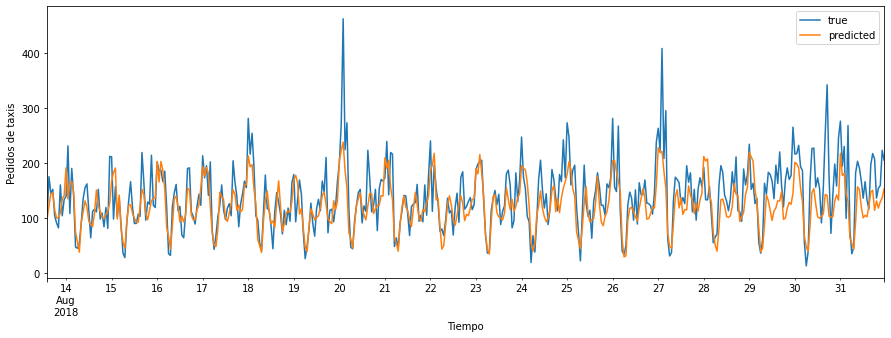

In [20]:
true_and_predicted = pd.DataFrame({'true': y_test, 'predicted': predict_valid}, index=y_test.index )
true_and_predicted.plot(figsize=(15,5))
plt.ylabel('Pedidos de taxis')
plt.xlabel('Tiempo')

Se puede observar que aunque hayan diferencias, el modelo puede predecir los picos hasta cierto punto. Dado que el máximo error permito era de 48, podemos aceptar este modelo con estos parámetros.

## Conclusión

Contamos con los datos históricos de pedidos de taxis en un aeropuerto, el objetivo es crear un modelo para predecir los pedidos de taxis en la próxima hora. Los datos disponibles estaban en un intervalo de cada 10 minutos, por lo que se remuestreó los datos para que el intervalo fuera de una hora. Los datos estaban limpios, sin valores ausentes, no fue necesario procesar más los datos.

Luego se revisó el rango de nuestras fechas disponibles. Tenemos los datos de 6 meses, desde el 1 de marzo del 2018, hasta el 31 de agosto del mismo año. Se obtuvo la estacionalidad de la primera semana, donde se observó que los datos seguían un patrón repetitivo cada hora. El pico máximo de pedidos en un día cualquiera ocurre a media noche mientras que el pedido mínimo ocurre a las 6 am. También hay una tendencia que muestra aumento del número de pedidos con el tiempo.

Se consideró para crear algunas características de calendario, como el mes, día del mes, día de la semana y hora. Además también se añadieron columnas que representaran el desfase de la columna objetivo y una media movil. 

Una vez añádidas las características, se empezó a entrenar modelos. Inicialmente se hizo una prueba de cordura, definiendo la predicción de cada tiempo t, como su valor anterior en el tiempo t-1. El RECM de esta prueba sirvió como valor máximo para la busqueda de parámetros que dieran el menor error. El mejor resultado para el conjunto de validación se dió con el modelo de LightGBM, el cuál obtuvo una métrica de 31.90. 

Al probar el conjunto de prueba, se obtuvo un RECM de 42.70. Este es mayor que nuestra métrica durante la validación, lo que indicaría que hay sobreajuste. Sin embargo, el modelo cumple con el objetivo que es que la métrica diera menor a 48, lo que nos permite aceptar este modelo.